# Preliminary Analysis

In this page, we do a first analysis of finding how many new developments are within 1km of an SBI, and why we chose this as our metric for then deciding the heurisic of which sites are at risk.

## Example code - Calculating distances between centroids

Load and join up the example data:

In [51]:
import geopandas as gpd
import pandas as pd

# Load and join GMCA housing, industrial and office supply data

housing_supply_gdf = gpd.read_file("data/gmca_data/2024 GM Housing Land Supply GIS.shp")
industrial_supply_gdf = gpd.read_file("data/gmca_data/2024 GM Industrial-warehousing Land Supply GIS.shp")
offices_supply_gdf = gpd.read_file("data/gmca_data/2024 GM Offices Land Supply GIS.shp")

total_supply_gdf = pd.concat(
    [housing_supply_gdf, industrial_supply_gdf, offices_supply_gdf]
)

# Load and tidy GMEU Sites of Biological Importance data

sbi_gdf = gpd.read_file("data/gmeu_data/gm_sbi.shp")

sbi_gdf["Category"] = "Site of Biological Importance"

sbi_gdf = sbi_gdf.rename(columns = {"district": "LAName", "site_nam": "SiteRef"})

# Join GMCA and GMEU data

full_data_gdf = pd.concat(
    [total_supply_gdf, sbi_gdf[["SiteRef", "LAName", "Category", "geometry"]]]
)

We can use GeoPandas to get the centroids of all our data:

In [52]:
full_data_gdf["centroid"] = full_data_gdf.centroid

Now we can extract the location of a random SBI and a random proposed development site:

In [53]:
random_sbi = full_data_gdf[
    full_data_gdf["Category"] == "Site of Biological Importance"
    ].sample(1)

random_sbi = random_sbi["centroid"].iloc[0]

print(random_sbi)

POINT (397362.4758006082 389256.60739862215)


In [54]:
random_housing = full_data_gdf[
    full_data_gdf["Category"] == "Housing"
    ].sample(1)

random_housing = random_housing["centroid"].iloc[0]

print(random_housing)

POINT (389684.93350784713 389911.28378826106)


The distance between two Point objects can be calculated using Shapely:

In [55]:
import shapely

print(
    round(shapely.distance(random_housing, random_sbi), 2)
)

7705.4


## Calculating distances between centroids to classify locations as at risk

The main part of this project is now to use this methodology to repeat for all of the SBI sites, and find which ones have the most new property developments near them and therefore figure out which are the most at risk.

In [56]:
#Find distance between one point and all other points

sbi = full_data_gdf[full_data_gdf["Category"] == "Site of Biological Importance"]
non_sbi = full_data_gdf[full_data_gdf["Category"] != "Site of Biological Importance"]

example_distances = non_sbi["centroid"].distance(random_sbi)
#finds the difference to one random sbi from all of the developments


Using this we can then find how many developments are within xkm of each SBI.

In [57]:
#Find the number of new developments less than 1km away for each SBI

sbinames = list(sbi["SiteRef"]) #list of all the sbis

distances = list()
less_than_1km = list() #creating empty lists to add to data frame

for x in sbi["centroid"]: #loop through each sbi
    y = non_sbi["centroid"].distance(x) #find all the distances of developments to centroid
    for distance in y: #filter for less than 1km away
            if distance <1000:
                distances.append(distance)
    r = len(distances)    #find no. developments less than 1km away to each sbi
    less_than_1km.append(r)
    distances = list()



Dev_1km = pd.DataFrame({'SBI Name':sbinames, 'No. Sites in 1km': less_than_1km}) #create dataframe of sbi and no. developments
             
Dev_1km
                
  


,SBI Name,No. Sites in 1km
0,Big Wood,0
1,Winstanley Hall Woods,1
2,Ackhurst Lane Sand Workings,3
3,Abbey Lakes,6
4,Wetland by M6,1
...,...,...
531,Mill Race & Pasture at Haughton Dale,8
532,Three Sisters,2
533,Nan Nook Wood,7
534,Big Wood,10


Then, to consider how useful 1km is as a metric, we can plot a graph of the distribution of frequency of new developments near an SBI.

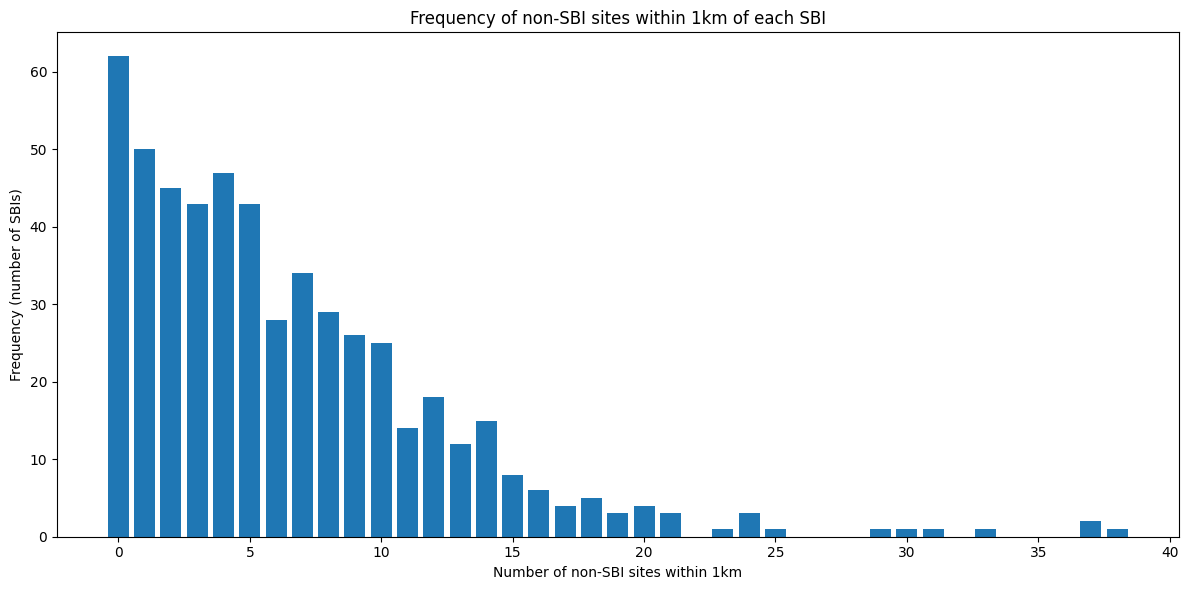

In [58]:
#See the distribution of the number of sites near the sbi to choose "at risk"
import matplotlib.pyplot as plt


# Calculate frequencies of non-SBI site counts within 1km of each SBI
import collections
freq = collections.Counter(less_than_1km)


# Sort by number of sites for x-axis order
counts = sorted(freq.items())
x, y = zip(*counts)
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xlabel('Number of non-SBI sites within 1km')
plt.ylabel('Frequency (number of SBIs)')
plt.title('Frequency of non-SBI sites within 1km of each SBI')
plt.tight_layout()
plt.show()



To compare we can do this for 1.5km too, to ensure 1km is a good choice.

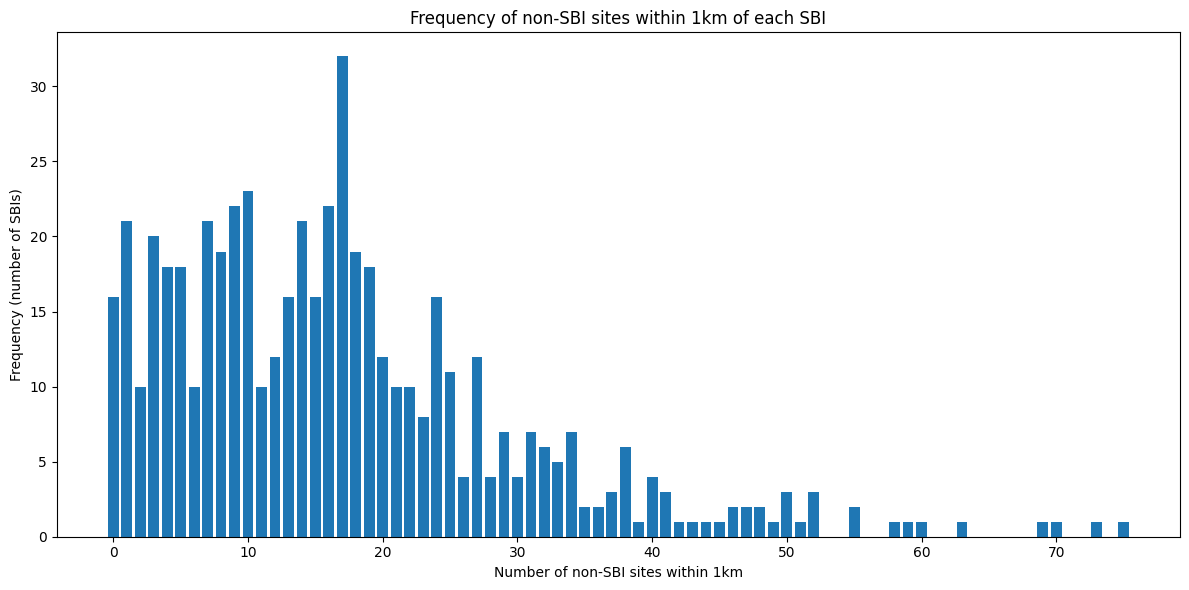

In [59]:
#Similarly, for 1.5km


distances = list()
less_than_1km = list() #creating empty lists to add to data frame

for x in sbi["centroid"]: #loop through each sbi
    y = non_sbi["centroid"].distance(x) #find all the distances of developments to centroid
    for distance in y: #filter for less than 1km away
            if distance <1500:
                distances.append(distance)
    r = len(distances)    #find no. developments less than 1km away to each sbi
    less_than_1km.append(r)
    distances = list()


#See the distribution of the number of sites near the sbi to choose "at risk"
import matplotlib.pyplot as plt


# Calculate frequencies of non-SBI site counts within 1km of each SBI
import collections
freq = collections.Counter(less_than_1km)


# Sort by number of sites for x-axis order
counts = sorted(freq.items())
x, y = zip(*counts)
plt.figure(figsize=(12, 6))
plt.bar(x, y)
plt.xlabel('Number of non-SBI sites within 1km')
plt.ylabel('Frequency (number of SBIs)')
plt.title('Frequency of non-SBI sites within 1km of each SBI')
plt.tight_layout()
plt.show()

From these graphs, the 1.5km graph is a lot more spread out, and 70 new developments is a very large number, and most likely refers to small developments, whereas there may be one SBI with a few large developments that would not be captured here, hence 1km is the better choice for this case.

In [60]:
#Choosing the "at risk" threshold, from the graph above choose: >20 at risk, >30 highly at risk
sbi = full_data_gdf[full_data_gdf["Category"] == "Site of Biological Importance"]

Dev_1km= Dev_1km
Dev_1km["moderate risk"] = Dev_1km["No. Sites in 1km"] >=15 
Dev_1km["major risk"] = Dev_1km["No. Sites in 1km"] >=30

Dev_1km



,SBI Name,No. Sites in 1km,moderate risk,major risk
0,Big Wood,0,False,False
1,Winstanley Hall Woods,1,False,False
2,Ackhurst Lane Sand Workings,3,False,False
3,Abbey Lakes,6,False,False
4,Wetland by M6,1,False,False
...,...,...,...,...
531,Mill Race & Pasture at Haughton Dale,8,False,False
532,Three Sisters,2,False,False
533,Nan Nook Wood,7,False,False
534,Big Wood,10,False,False


In [61]:
#Scaled Risk 
bins = [-1, 0, 10, 20, 30, 40] #upper limit inclusive
labels = [1, 2, 3, 4, 5]
Dev_1km["Risk Scale"] = pd.cut(Dev_1km["No. Sites in 1km"], bins=bins, labels=labels)

Dev_1km

,SBI Name,No. Sites in 1km,moderate risk,major risk,Risk Scale
0,Big Wood,0,False,False,1
1,Winstanley Hall Woods,1,False,False,2
2,Ackhurst Lane Sand Workings,3,False,False,2
3,Abbey Lakes,6,False,False,2
4,Wetland by M6,1,False,False,2
...,...,...,...,...,...
531,Mill Race & Pasture at Haughton Dale,8,False,False,2
532,Three Sisters,2,False,False,2
533,Nan Nook Wood,7,False,False,2
534,Big Wood,10,False,False,2


In [62]:
# Alternate way of calculating risk: percentiles
import numpy as np

twenty = np.percentile(Dev_1km["No. Sites in 1km"], 20 )
forty = np.percentile(Dev_1km["No. Sites in 1km"], 40 )
sixty = np.percentile(Dev_1km["No. Sites in 1km"], 60 )
eighty = np.percentile(Dev_1km["No. Sites in 1km"], 80 )
hundred = np.percentile(Dev_1km["No. Sites in 1km"], 100 )

bins = [-1, twenty, forty, sixty, eighty, hundred ] #upper limit inclusive
labels = [20, 40, 60, 80, 100]

Dev_1km["Percentile Scale"] = pd.cut(Dev_1km["No. Sites in 1km"], bins=bins, labels=labels)

Dev_1km

,SBI Name,No. Sites in 1km,moderate risk,major risk,Risk Scale,Percentile Scale
0,Big Wood,0,False,False,1,20
1,Winstanley Hall Woods,1,False,False,2,20
2,Ackhurst Lane Sand Workings,3,False,False,2,40
3,Abbey Lakes,6,False,False,2,60
4,Wetland by M6,1,False,False,2,20
...,...,...,...,...,...,...
531,Mill Race & Pasture at Haughton Dale,8,False,False,2,80
532,Three Sisters,2,False,False,2,40
533,Nan Nook Wood,7,False,False,2,60
534,Big Wood,10,False,False,2,80
